In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import os 
from habitat_sim.agent.controls.controls import SceneNodeControl
import open3d as o3d
import numpy as np
from dataset.habitat.simulator import init_sim 
from plyfile import PlyData, PlyElement

# local import 
from scene_graph.scene_graph_cls import SceneGraphHabitat
from scene_graph.config import SceneGraphHabitatConfig
from scene_graph.utils import visualize_scene_graph, getOBB
from scene_graph.scene_graph_pred import SceneGraphPredictor

def parse_args(input=""):

    parser = argparse.ArgumentParser()
    parser.add_argument("--scan_dir", type=str, default="/media/junting/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans")
    parser.add_argument("--scene_name", type=str, default="17DRP5sb8fy")
    parser.add_argument("--dataset", type=str, default="matterport")
    
    parser.add_argument("--visualize", type=int, default=1)
    parser.add_argument("--vis_mode", type=str, default="segment", choices=["rgb", "segment"])
    
    parser.add_argument("--rel_dist_thresh", type=float, default=2.0, help="threshold of max distance between two objects that could have a relationship")

    args = parser.parse_args(input)  
    args.scene_ply_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_semantic.ply')
    args.scene_glb_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}.glb')
    args.pclseg_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_pclseg.txt')
    args.pcl_normals_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_normals.npy')
    args.house_file_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}.house')
    return args 




In [2]:
args = parse_args()
############ load ground truth pointclouds ####################
# o3d_pcl = o3d.io.read_point_cloud(args.scene_ply_path) # only load vertices 
# scene = o3d.io.read_triangle_mesh(args.scene_ply_path) # load mesh file \


In [3]:
############ initialize habitat simulator and ground truth scene graph ########
sim, action_names, sim_settings = init_sim(args.scene_glb_path)

I1125 15:49:39.141994 42515 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1125 15:49:39.142017 42515 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1125 15:49:42.677098 42515 simulator.py:221] Loaded navmesh /media/junting/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans/17DRP5sb8fy/17DRP5sb8fy.navmesh
I1125 15:49:39.142112 42515 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1125 15:49:39.142138 42515 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
I1125 

Renderer: GeForce RTX 3080/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 460.91.03
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
agent_state: position [0. 0. 0.] rotation quaternion(1, 0, 0, 0)
sensor_states: {'rgb': SixDOFPose(position=array([0. , 1.5, 0. ], dtype=float32), rotation=quaternion(1, 0, 0, 0)), 'depth': SixDOFPose

frame) created and registered.
I1125 15:49:39.142204 42515 AssetAttributesManager.cpp:120] Asset attributes (cylinderSolid : cylinderSolid_rings_1_segments_12_halfLen_1_useTexCoords_false_useTangents_false_capEnds_true) created and registered.
I1125 15:49:39.142220 42515 AssetAttributesManager.cpp:120] Asset attributes (cylinderWireframe : cylinderWireframe_rings_1_segments_32_halfLen_1) created and registered.
I1125 15:49:39.142228 42515 AssetAttributesManager.cpp:120] Asset attributes (icosphereSolid : icosphereSolid_subdivs_1) created and registered.
I1125 15:49:39.142235 42515 AssetAttributesManager.cpp:120] Asset attributes (icosphereWireframe : icosphereWireframe_subdivs_1) created and registered.
I1125 15:49:39.142246 42515 AssetAttributesManager.cpp:120] Asset attributes (uvSphereSolid : uvSphereSolid_rings_8_segments_16_useTexCoords_false_useTangents_false) created and registered.
I1125 15:49:39.142257 42515 AssetAttributesManager.cpp:120] Asset attributes (uvSphereWireframe :

In [4]:
%reload_ext autoreload
import sys
from importlib import reload

# del sys.modules['scene_graph.scene_graph_cls'] 
from scene_graph import scene_graph_cls
from scene_graph.config import SceneGraphHabitatConfig

# intialize ground truth scene graph 
config = SceneGraphHabitatConfig()
sg = scene_graph_cls.SceneGraphHabitat(config, scene_name=args.scene_name)
sg.load_gt_scene_graph(args.scene_ply_path, args.pclseg_path, args.pcl_normals_path, sim) 

 10%|█         | 1/10 [00:00<00:01,  8.78it/s]

100%|██████████| 10/10 [00:00<00:00, 10.95it/s]


In [6]:
%reload_ext autoreload
from scene_graph.utils import visualize_scene_graph 
########### visualize loaded scene with bounding boxes ########################
if args.visualize:
    visualize_scene_graph(sg, free_space_vis=True, house_file_path=args.house_file_path)


## Test the trasnsformation from habitat to mp3d

In [5]:
####### check scene graph ###############
print('Region 0 Center: {}'.format(sim.semantic_scene.regions[0].aabb.center))
print('Region 0 Sizes: {}'.format(sim.semantic_scene.regions[0].aabb.sizes))

Region 0 Center: [-8.821845   1.2594094 -2.691538 ]
Region 0 Sizes: [4.163309  2.5356622 4.2073426]


In [6]:
from dataset.habitat.utils import read_house_file
house_dict, meta_dict = read_house_file(args.house_file_path)

In [30]:
######## calculate full rotation between habitat and mp3d #########
from scipy.spatial.transform import Rotation as R
from habitat_sim.utils.common import quat_from_two_vectors, quat_to_coeffs
import quaternion as qt

'''
# definitions from habitat 
static const vec3f ESP_UP = vec3f::UnitY();
//! global/world gravity (down) direction
static const vec3f ESP_GRAVITY = -ESP_UP;
//! global/world front direction
static const vec3f ESP_FRONT = -vec3f::UnitZ();
//! global/world back direction
static const vec3f ESP_BACK = -ESP_FRONT;
...
const quatf alignGravity = quatf::FromTwoVectors(-vec3f::UnitZ(), ESP_GRAVITY);
const quatf alignFront = quatf::FromTwoVectors(-vec3f::UnitX(), ESP_FRONT);
const quatf& rotation = alignFront * alignGravity;
'''

quat_alignGravity = quat_from_two_vectors(np.array([0, 0, -1]), np.array([0, -1, 0]))
quat_test = quat_from_two_vectors(np.array([0, -1, 0]), np.array([0, 0, -1]))
# quat_alignFront = quat_from_two_vectors(np.array([-1, 0, 0]), np.array([0, 0, -1]))
# quat_m2h = quat_alignFront * quat_alignGravity
# r_m2h = qt.as_rotation_matrix(quat_m2h)
r_m2h = qt.as_rotation_matrix(quat_alignGravity)
r_h2m = np.linalg.inv(r_m2h)
print(r_h2m @ qt.as_rotation_matrix(quat_test))

[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00 -4.4408921e-16]
 [ 0.0000000e+00  4.4408921e-16 -1.0000000e+00]]


In [26]:
###################### test region bbox coords transformation ####################
# region_dict = house_dict['R'][0]
# print(f"house annotation: region id {region_dict['region_index']}, label {region_dict['label']}")

# target_habitat_center = np.array([-8.82185,1.25941,-2.69154])
# center = np.array([
#     (float(region_dict['xhi']) + float(region_dict['xlo']))/2.,
#     (float(region_dict['yhi']) + float(region_dict['ylo']))/2.,
#     (float(region_dict['zhi']) + float(region_dict['zlo']))/2.,
# ])
# sizes = np.array([
#     float(region_dict['xhi']) - float(region_dict['xlo']),
#     float(region_dict['yhi']) - float(region_dict['ylo']),
#     float(region_dict['zhi']) - float(region_dict['zlo']),
# ])
# print(r_m2h @ center)
# print(np.abs(r_m2h @ sizes) )

house annotation: region id 0, label b
[-8.821845    1.25940913 -2.6915385 ]
[4.16331    2.53566175 4.207343  ]


In [53]:
###################### test object bbox coords transformation ####################
vis_box_list = []
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5, origin=[0, 0, 0])
vis_box_list.append(axis_pcd)

# ground truth bounding box from .house  
object_dict = house_dict['O'][0]
print(f"house annotation: object id {object_dict['object_index']}, label {object_dict['category_index']}")
center, sizes, r_mat = getOBB(object_dict)
house_object_obb = o3d.geometry.OrientedBoundingBox(center, r_mat, sizes)
house_object_obb.color = (1,0,1) # gt: purple 
# house_object_obb.rotate(r_m2h)
vis_box_list.append(house_object_obb)

# bounding box from habitat 
object_node = sim.semantic_scene.objects[0]
habitat_object_obb = o3d.geometry.OrientedBoundingBox(
    object_node.obb.center,
    R.from_quat(object_node.obb.rotation).as_matrix(),
    object_node.obb.sizes
)
habitat_object_obb.rotate(r_h2m, (0,0,0))
habitat_object_obb.color = (0,1,0)
vis_box_list.append(habitat_object_obb)

o3d.visualization.draw_geometries(vis_box_list)

house annotation: object id 0, label 0


In [36]:
########## try to get all translations of regions bbox 
translations = []
habitat_region_inverse_mapping = {int(r.id.split("_")[-1]):r for r in sim.semantic_scene.regions}
for region_dict in house_dict['R']:
    size_x = float(region_dict['xhi']) - float(region_dict['xlo'])
    size_y = float(region_dict['yhi']) - float(region_dict['ylo'])
    size_z = float(region_dict['zhi']) - float(region_dict['zlo'])
    position = np.array([float(region_dict['px']), float(region_dict['py']), float(region_dict['pz'])])
    center = np.array([
        (float(region_dict['xhi']) + float(region_dict['xlo']))/2,
        (float(region_dict['yhi']) + float(region_dict['ylo']))/2,
        (float(region_dict['zhi']) + float(region_dict['zlo']))/2,
    ])
    region_idx = int(region_dict['region_index'])
    # print(f"house annotation: region id {region_idx}, label {region_dict['label']}: difference between position and center is {center-position}")
    sizes = np.array([size_x, size_y, size_z])

    habitat_region = habitat_region_inverse_mapping[region_idx]
    # t = center @ r_m2h - habitat_region.aabb.center 
    t = r_h2m @ habitat_region.aabb.center - center  
    # print(f"From .house, region id {region_idx}, label {region_dict['label']}; \
    #     From habitat, region id {habitat_region.id.split('_')[-1]}, label {habitat_region.category}, translation {t}")

    translations.append(t)
    # break # test one region 
print(translations)

## Test free space grid points 

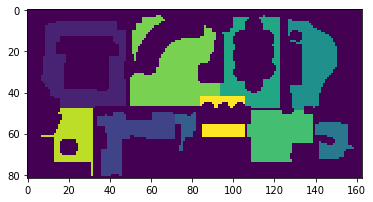

In [15]:
######
from scene_graph.utils import grid_xz_to_points
import matplotlib.pyplot as plt 

segment_grid = sg.region_layer.segment_grid
# convert grid to index array and label array 
idx_list = [[i,j] for i in range(segment_grid.shape[0]-1)
    for j in range(segment_grid.shape[1]-1)]
seg_arr = np.array([segment_grid[idx[0], idx[1]] for idx in idx_list])
idx_arr = np.array(idx_list)

free_space_points = grid_xz_to_points(sg.scene_bounds, idx_arr, 
    sg.height - 0.5, sg.meters_per_grid)

plt.imshow(segment_grid)

# free_space_o3d = o3d.geometry.PointCloud()
# free_space_o3d.points = o3d.utility.Vector3dVector(free_space_points)
# max_label = seg_arr.max()
# colors = plt.get_cmap(pcl_color_map)( seg_arr/ (max_label+1))
# free_space_o3d.colors = o3d.utility.Vector3dVector(colors[:,:3])
# if mp3d_coord:
#     free_space_o3d.rotate(r_h2m, (0,0,0))

# o3d_vis_list.append(free_space_o3d)

## Test feature extractor 

In [17]:
############ extract GCN features by pretrained 3DSSG model 
feature_extractor = SceneGraphPredictor(args.rel_dist_thresh)
object_nodes = [sg.object_layer.obj_dict[obj_id]
    for obj_id in sg.object_layer.obj_ids]

''' 
extractor returns a dictionary:  
results={
    "pred_obj_prob": pred_obj_prob, # (N, D) numpy array
    "pred_obj_confidence": pred_obj_confidence, # (N,) numpy array
    "pred_obj_label": pred_obj_label, # (N,) numpy array 
    "edges": edges, # (M,2) numpy array, represented by object index (not id!)
    "pred_rel_prob": pred_rel_prob, # (M,2)
    "pred_rel_confidence": pred_rel_confidence,
    "pred_rel_label": pred_rel_label
}
'''
# object center, bounding box, 
results = feature_extractor.predict(object_nodes)

==trainable parameters==
obj_encoder 73976
rel_encoder 42112
gcn 5274368
obj_predictor 399124
rel_predictor 265225


Loading CVPR21 model...
	No checkpoints, but has saved best model. Load the best model
	model loaded!



In [18]:
results

{'pred_obj_prob': array([[5.43670632e-13, 3.33392369e-10, 8.52218018e-10, ...,
         1.08563896e-11, 9.99996245e-01, 3.79491744e-10],
        [7.21649606e-12, 8.85670701e-08, 2.43640965e-08, ...,
         1.58955384e-11, 1.45906262e-04, 2.38754155e-11],
        [2.32389084e-07, 9.85909355e-05, 1.85561902e-03, ...,
         1.31092647e-05, 6.37336983e-04, 1.45647309e-05],
        ...,
        [2.91040803e-10, 9.59892259e-06, 3.90241039e-09, ...,
         2.61893233e-11, 5.38739641e-07, 2.74338530e-09],
        [8.94456384e-11, 1.13625936e-06, 2.24814833e-10, ...,
         5.97160071e-13, 2.24554375e-09, 3.50562579e-09],
        [1.00515835e-13, 1.27256099e-08, 4.97972535e-04, ...,
         1.70886072e-09, 2.65248518e-10, 1.41304758e-04]], dtype=float32),
 'pred_obj_confidence': tensor([1.0000, 0.5023, 0.6417, 0.3752, 0.3039, 0.9756, 0.8422, 1.0000, 0.9376,
         0.9999, 1.0000, 0.6242, 0.9764, 0.7498, 0.9940, 0.9488, 0.9517, 1.0000,
         0.9996, 0.6939, 0.9977, 0.9682, 0.9999,